**Task: To create a model that can predict sales of given store.**

Here we are going to implement SARIMA model and a machine learning model (XGBoost) to predict the future sales. This project is self learning project where I will start with basic Data Exploration and then Transformation of data as required by the models. For time series problem, various properties of data are explored like stationarity and trend. Data Visualization is performed to better understand the underlying data.

This work is referenced from [Link](https://medium.com/analytics-vidhya/predicting-sales-time-series-analysis-forecasting-with-python-b81d3e8ff03f)

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller # test to check stationarity of the time series
from statsmodels.tsa.seasonal import seasonal_decompose # to check seasonality and trend
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # to plot Autocorrelation and Partial Autocorrelation graphs
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
import xgboost as xgb
from xgboost import plot_importance
import datetime
import warnings
warnings.filterwarnings("ignore")

Files are downloaded from this [Link](https://www.kaggle.com/competitions/rossmann-store-sales/data)

In [2]:
# read store.csv file and check top 5 rows
store_df = pd.read_csv("/content/store.csv")
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [3]:
print(np.unique(store_df["StoreType"]))
len(np.unique(store_df["StoreType"]))

['a' 'b' 'c' 'd']


4

In [4]:
# read train.csv file which contains all the training data and check top 5 rows
train_df = pd.read_csv("/content/train.csv")
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,31/07/2015,5263,555,1,1,0,1
1,2,5,31/07/2015,6064,625,1,1,0,1
2,3,5,31/07/2015,8314,821,1,1,0,1
3,4,5,31/07/2015,13995,1498,1,1,0,1
4,5,5,31/07/2015,4822,559,1,1,0,1


In [5]:
type(train_df["Date"][0])

str

In [6]:
# The Date column in above dataframe contains string type values, convert them to datetime type
train_df["Date"] = pd.to_datetime(train_df["Date"])
train_df["Date"]

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, Length: 1017209, dtype: datetime64[ns]

In [7]:
# print information about the dataframe, know the datatype and null values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [8]:
# number of stores in the dataframe
len(np.unique(train_df["Store"]))

1115

In [9]:
train_df1 = train_df.groupby(["Store", "Date"]).sum()
train_df1

DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday
Store Date                                                               
1     2013-01-01          2      0          0     0      0              1
      2013-01-02          5   5633        658     1      0              0
      2013-01-03          5   4611        584     1      0              0
      2013-01-04          1      0          0     0      0              1
      2013-01-05          3      0          0     0      1              0
...                     ...    ...        ...   ...    ...            ...
1115  2015-12-03          4   5376        393     1      0              0
      2015-12-04          7      0          0     0      0              0
      2015-12-05          2   5570        402     1      0              0
      2015-12-06          5   5315        378     1      0              0
      2015-12-07          7      0          0     0      0              0

[1017209 rows x 6 columns]

In [10]:
# get information about store 1 only
store1_df = train_df1.loc[1]
store1_df

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Date,,,,,,
2013-01-01,2,0,0,0,0,1
2013-01-02,5,5633,658,1,0,0
2013-01-03,5,4611,584,1,0,0
2013-01-04,1,0,0,0,0,1
2013-01-05,3,0,0,0,1,0
...,...,...,...,...,...,...
2015-12-03,4,3141,405,1,0,0
2015-12-04,7,0,0,0,0,0
2015-12-05,2,3547,438,1,0,0


Let's join both the available datasets (store and train) in a way that we can get the information about stores in train dataset from store dataset.

In [11]:
train_store_df = pd.merge(train_df, store_df, on='Store' ,how='left')
train_store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
# take month data from date column and put in a separate column in dataframe
train_store_df["Month"] = list(map(lambda x: x.month, train_store_df["Date"]))
train_store_df["Month"]

0          7
1          7
2          7
3          7
4          7
          ..
1017204    1
1017205    1
1017206    1
1017207    1
1017208    1
Name: Month, Length: 1017209, dtype: int64

In [13]:
# take Year data from date column and put in a separate column in dataframe
train_store_df["Year"] = list(map(lambda x: x.year, train_store_df["Date"]))
train_store_df["Year"]

0          2015
1          2015
2          2015
3          2015
4          2015
           ... 
1017204    2013
1017205    2013
1017206    2013
1017207    2013
1017208    2013
Name: Year, Length: 1017209, dtype: int64

In [14]:
# check column names in train_store_df
train_store_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Month', 'Year'],
      dtype='object')

In [15]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

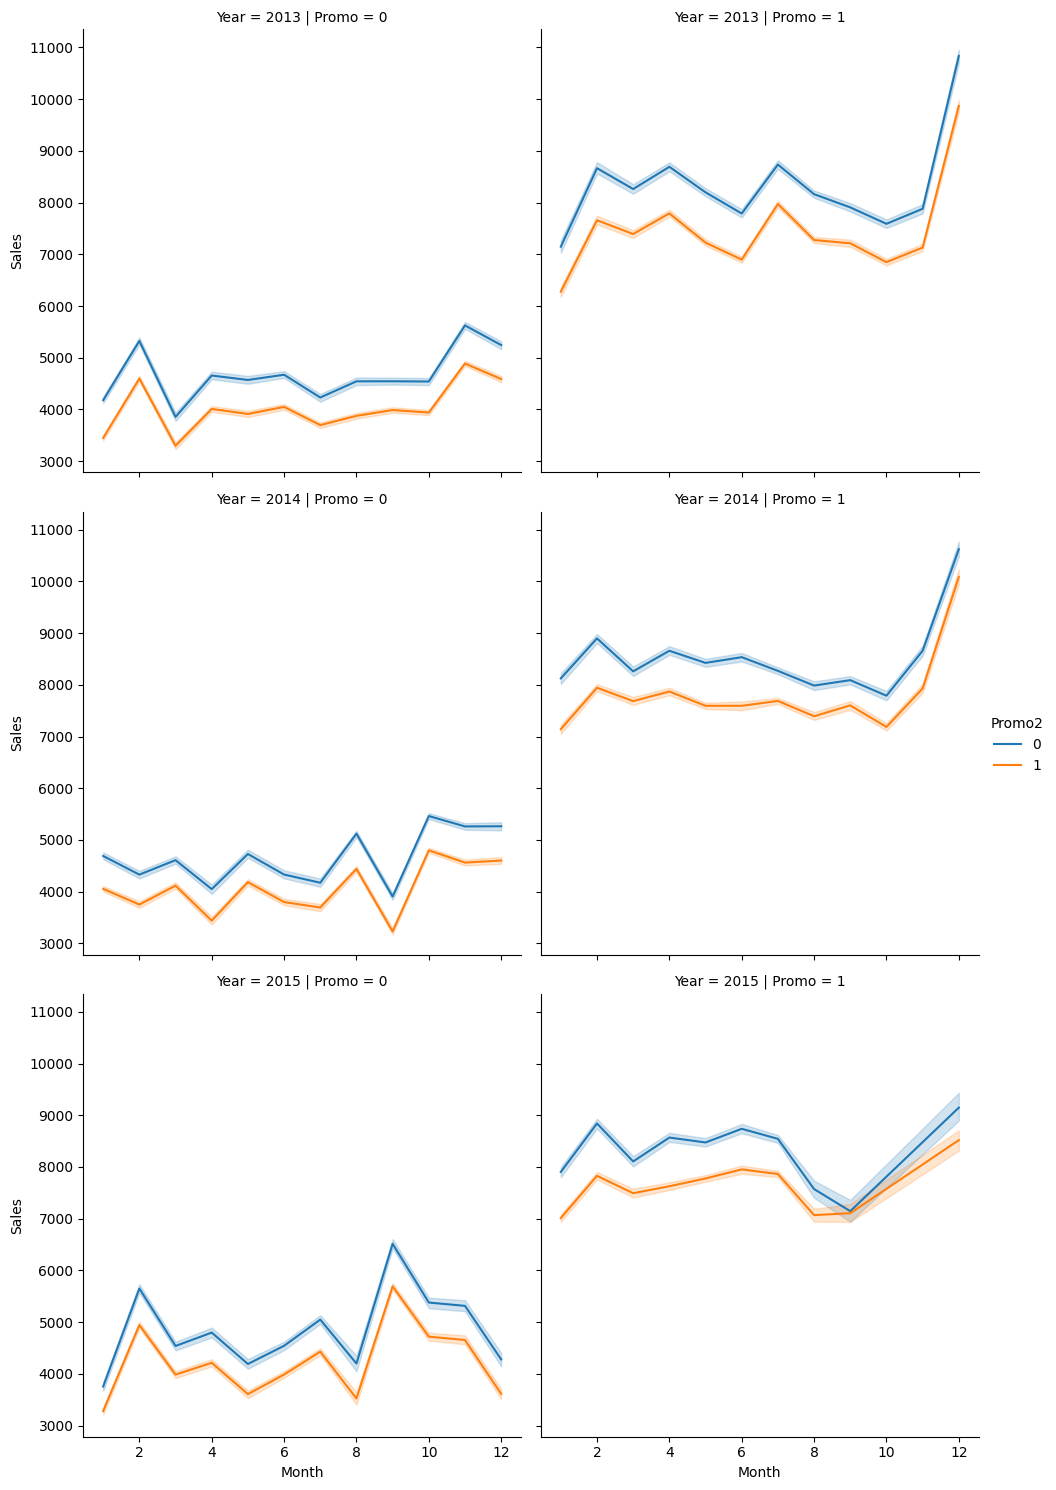

In [16]:
# visualise the sales for each year corresponding to the month
# and compare between sales when promo is running and when its not
sns.relplot(x ='Month', y ='Sales', data = train_store_df,  kind="line", hue = "Promo2", col = 'Promo', row = "Year")

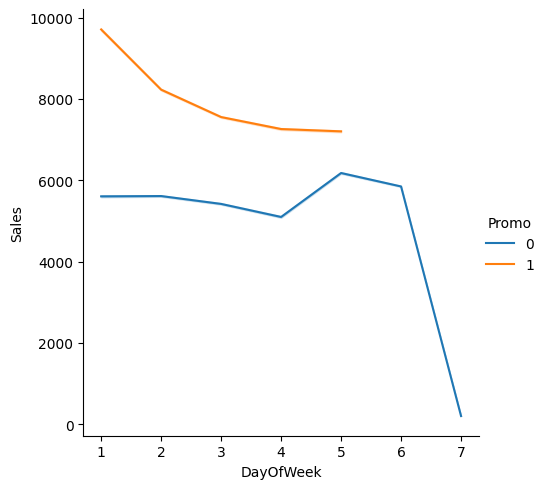

In [17]:
# plot number of sales on different days of week
sns.relplot(x ='DayOfWeek', y ='Sales', data = train_store_df,  kind="line", hue = "Promo")

From the above graph, it can be seen that the promos are not running on weekends. When there is promo, highest sales are on Mondays(1st day).  

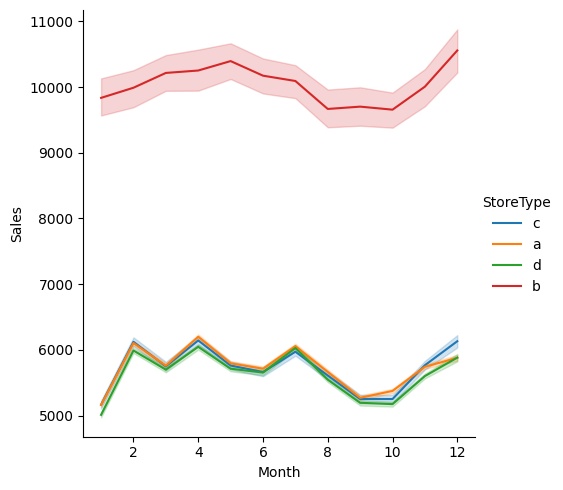

In [18]:
sns.relplot(x ='Month', y ='Sales', data = train_store_df,  kind="line", hue = "StoreType")

From above, it can be seen that store b has a lot higher sales than other store (it will be good to figure out the reason, reason could be the location, less compititors in area, we can do it in future).

### Check Stationarity of Time Series

Data is stationary if it has constant mean and constant variance with time. Two ways to check stationarity: Rolling mean and Dicky-Fuller test.

**Rolling mean**: a rolling window on weekly basis, on which average is taken on weekly basis. Rolling Statistics is a visualization test where the original data with the rolled data is compared to check if the data is stationary.

**Dicky-Fuller test**: This test provides as statistical data such as p-value to understand wheather we can understand if we can reject null hypothesis. Null hypothesis is that data is not stationary and alternative hypothesis is that it is stationary. If p-value is less than critical value(<0.05), we will reject the null hypothesis and say that data is stationary.

In [19]:
# Data Preparation: input should be float type
train_store_df["Sales"] = train_store_df["Sales"]*1.0

<Axes: xlabel='Date'>

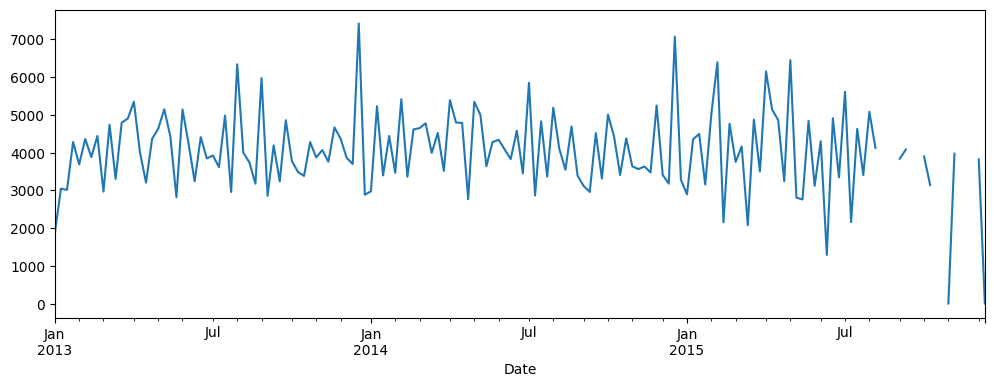

In [20]:
# let's take type a stores
sales_a_df = train_store_df[(train_store_df["StoreType"]=="a") & (train_store_df["Store"]==2)]
sales_a = sales_a_df["Sales"]
sales_a.index = sales_a_df.Date
sales_a = sales_a.sort_index()

sales_a_resample = sales_a.resample('W').mean() #'W' to aggregate, or resample, by week
# data is resampled to change the frequency of our data to a higher or lower frequency, or when we want to convert irregular time-series data to regular time-series data

plt.figure(figsize=(12,4))
sales_a_resample.plot()

we can notice that some of the sales vales are missing in the sample, we can simply drop these values.

In [21]:
sales_a_resample.isnull().sum()

10

In [22]:
sales_a_resample = sales_a_resample.dropna()
sales_a_resample.isnull().sum()

0

In [23]:
sales_a_resample.index[-30:]

DatetimeIndex(['2015-03-15', '2015-03-22', '2015-03-29', '2015-04-05',
               '2015-04-12', '2015-04-19', '2015-04-26', '2015-05-03',
               '2015-05-10', '2015-05-17', '2015-05-24', '2015-05-31',
               '2015-06-07', '2015-06-14', '2015-06-21', '2015-06-28',
               '2015-07-05', '2015-07-12', '2015-07-19', '2015-07-26',
               '2015-08-02', '2015-08-09', '2015-09-06', '2015-09-13',
               '2015-10-04', '2015-10-11', '2015-11-01', '2015-11-08',
               '2015-12-06', '2015-12-13'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [24]:
# define a function to test stationarity of the above sales data
def test_stationarity(timeseries):
  # determining rolling statistics
  roll_mean = timeseries.rolling(window=7).mean()
  roll_std = timeseries.rolling(window=7).std()
  # plot this rolling statistics data
  plt.figure(figsize=(10,5))
  plt.plot(sales_a_resample, label='original')
  plt.plot(roll_mean.resample('W').mean(), label='rolling_mean')
  plt.plot(roll_std.resample('W').mean(), label='roll_std')
  plt.legend()
  plt.show()
  # Dicky-Fuller test
  result = adfuller(timeseries, autolag='AIC')
  print("adf-test statistics: ", result[0])
  print("p-value: %f"% result[1])
  print("number of lags used: ", result[2])
  print("number of observations used: ", result[3])
  print("whole result: ", result)

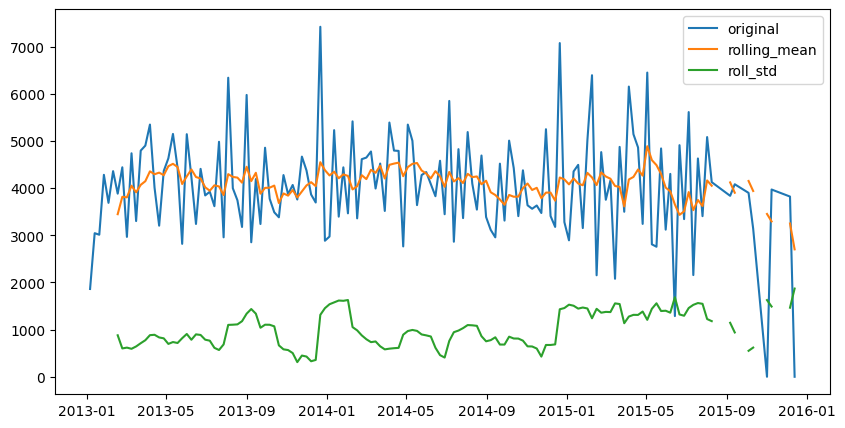

adf-test statistics:  -3.7565473246382006
p-value: 0.003385
number of lags used:  3
number of observations used:  140
whole result:  (-3.7565473246382006, 0.0033845280989275306, 3, 140, {'1%': -3.4779446621720114, '5%': -2.8824156122448983, '10%': -2.577901887755102}, 2164.753954493868)


In [25]:
test_stationarity(sales_a_resample)

We can see from the above plot and statistical test that mean and variation doesn’t change much with time, i.e they are constant. Thus, we don’t need to perform any transformation (needed when time series is not stationary).
Also the p-value is < 0.05, that is a strong evidence to reject the null hypothesis that the data is not stationary. Hence the data is stationary.

*Hints what to do when data is non-stationary: There are two things that can be done. First thing is differencing, means we have to shift the position of sales data. This is how we do it: sales_a - sales_a.shift(1) or we can do seasonal differencing by using shift(12).*

Now, let’s see the seasonality and trend using decomposition plots.

Text(0.5, 1.0, 'Decomposition Plots')

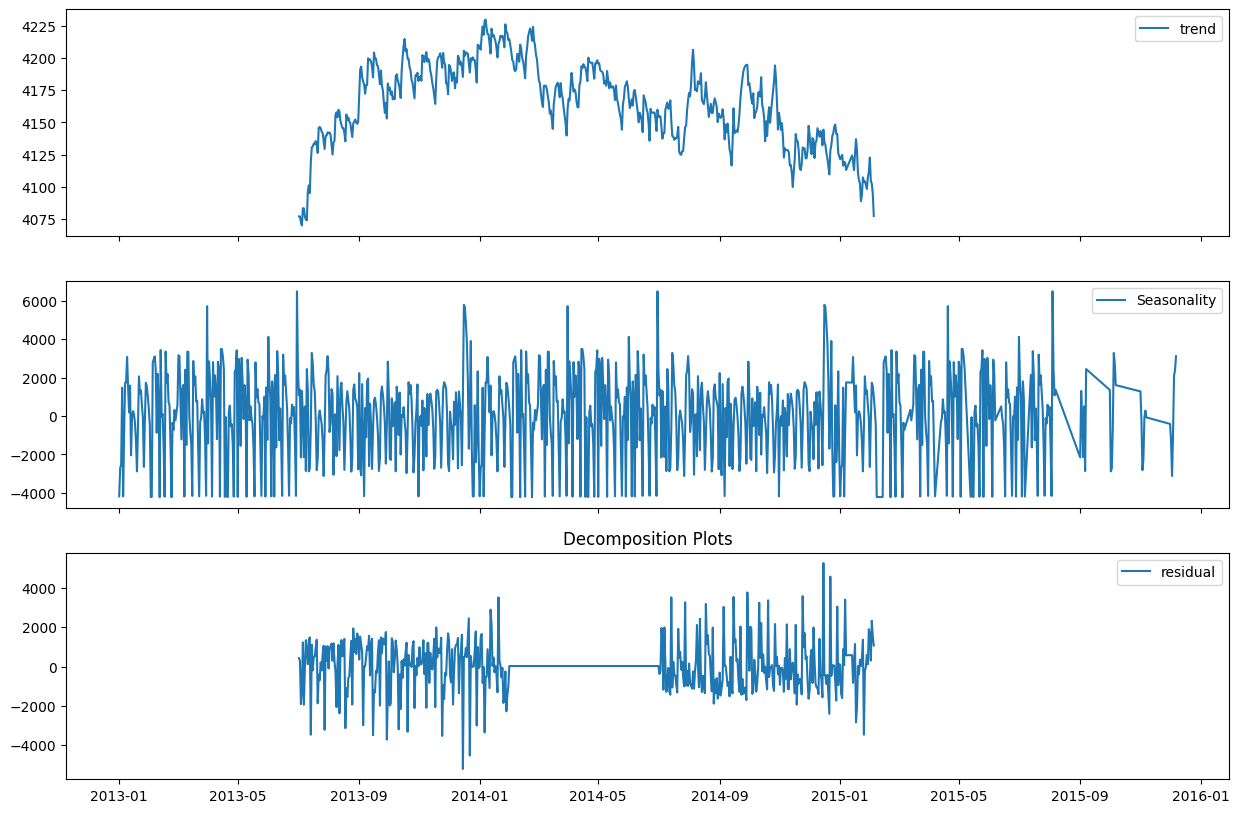

In [26]:
decomposition = seasonal_decompose(sales_a, model='additive', period=365) # or model can be Multiplicative
estimated_trend = decomposition.trend
estimated_seasonality = decomposition.seasonal
estimated_residual = decomposition.resid
fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)
axes[0].plot(estimated_trend, label="trend")
axes[0].legend()
axes[1].plot(estimated_seasonality, label="Seasonality")
axes[1].legend()
axes[2].plot(estimated_residual, label="residual")
axes[2].legend()
plt.title('Decomposition Plots')

From the above plots, we can see that there are seasonality and trend present in our data. So, we’ll use the forecasting models that take both of these factors into consideration.

### Forecasting: Predictive Modelling

#### ARIMA Model - AutoRegressive Integrated Moving Average

Identification of an AR model is often done using PACF (Partial Autocorrelation).
Identification of an MA model is best done using ACF (Autocorrelation).

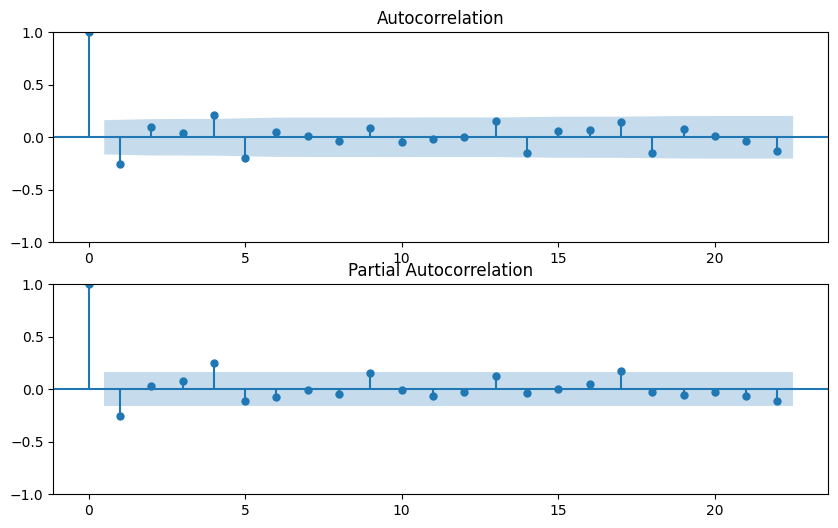

In [27]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sales_a_resample, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sales_a_resample, ax = ax2)

For ARIMA, order parameters here are p,d and q. p, d, and q represent seasonality, trend and noise in data respectively.

d (differences) must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include.

 Let's create all possible combination of these three parameters.

In [28]:
# Define the p, d and q parameters to take any value 0 and 1
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [29]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] # 12 is periodicity here
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

let's check Akaike information criterion (AIC) score for each combination. The combination with lowest AIC score will be the best in this case.

In [30]:
# Determing p,d,q combinations with AIC scores.
aicScoreDict = {}
for param in pdq:
  for param_seasonal in seasonal_pdq:
    mod = sm.tsa.statespace.SARIMAX(sales_a_resample, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit()
    aicScoreDict[param+param_seasonal] = results.aic
    #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
print(aicScoreDict)

{(0, 0, 0, 0, 0, 0, 12): 2793.0704984977046, (0, 0, 0, 0, 0, 1, 12): 2449.5931405413057, (0, 0, 0, 0, 1, 0, 12): 2289.653389126601, (0, 0, 0, 0, 1, 1, 12): 2038.0864278904294, (0, 0, 0, 1, 0, 0, 12): 2307.5603702280196, (0, 0, 0, 1, 0, 1, 12): 2266.880794907219, (0, 0, 0, 1, 1, 0, 12): 2078.2520583544074, (0, 0, 0, 1, 1, 1, 12): 2039.8698535476492, (0, 0, 1, 0, 0, 0, 12): 2707.2002664476213, (0, 0, 1, 0, 0, 1, 12): 2406.991449934073, (0, 0, 1, 0, 1, 0, 12): 2251.7134522018814, (0, 0, 1, 0, 1, 1, 12): 2008.226947716648, (0, 0, 1, 1, 0, 0, 12): 2298.5403174701905, (0, 0, 1, 1, 0, 1, 12): 2232.8018979228646, (0, 0, 1, 1, 1, 0, 12): 2067.6218139464277, (0, 0, 1, 1, 1, 1, 12): 2007.4302950145943, (0, 1, 0, 0, 0, 0, 12): 2519.2229851504553, (0, 1, 0, 0, 0, 1, 12): 2315.0479460459314, (0, 1, 0, 0, 1, 0, 12): 2408.02378446977, (0, 1, 0, 0, 1, 1, 12): 2115.5009768810824, (0, 1, 0, 1, 0, 0, 12): 2331.8445634125937, (0, 1, 0, 1, 0, 1, 12): 2316.9384739414754, (0, 1, 0, 1, 1, 0, 12): 2174.12610720

In [31]:
# get params that have minimum AIC
miniAic = min(aicScoreDict, key=aicScoreDict.get) # get the key value
min_order = miniAic[:3]
min_seasonal_order = miniAic[3:]
print(min_order, min_seasonal_order)

(1, 1, 1) (0, 1, 1, 12)


Let's fit the ARIMA model with above parameters

In [32]:
arima_mod = sm.tsa.statespace.SARIMAX(sales_a_resample, order=min_order, seasonal_order=min_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
results_sarima = arima_mod.fit()
print(results_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -988.321
Date:                            Wed, 18 Oct 2023   AIC                           1984.641
Time:                                    09:55:21   BIC                           1995.690
Sample:                                         0   HQIC                          1989.127
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4199      0.110     -3.830      0.000      -0.635      -0.205
ma.L1         -0.8318      0.066   

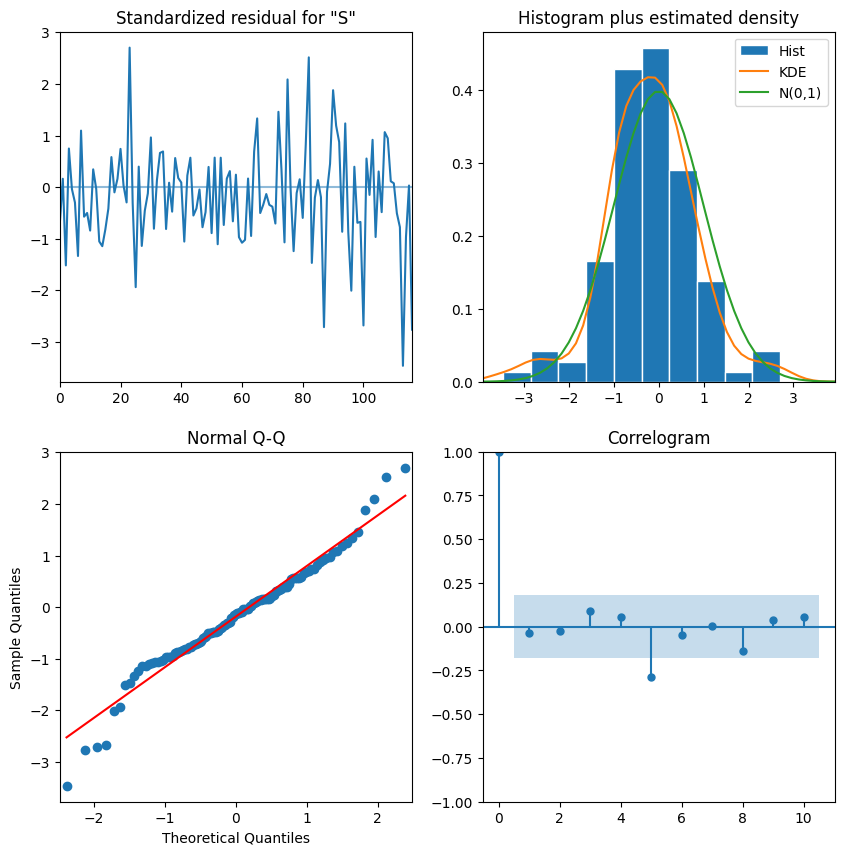

In [33]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

In [34]:
prediction = results_sarima.get_prediction(start=pd.to_datetime("2015-03-15"))
prediction_mean = prediction.predicted_mean

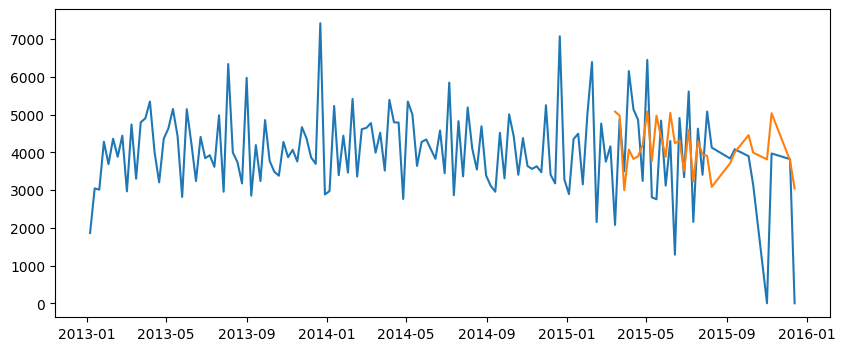

In [35]:
plt.figure(figsize=(10,4))
plt.plot(sales_a_resample)
plt.plot(prediction_mean)
plt.show()

In [36]:
# check RMSE score
train_arima_truth = sales_a_resample["2015-03-15":]

rms_arima = np.sqrt(mean_squared_error(train_arima_truth, prediction_mean))
print("Root Mean Squared Error: ", rms_arima)

Root Mean Squared Error:  1487.238259002655


RMSE is still high,means forecaste may not be that good. Let's try a Machine Learning model now.

### XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. Although it is not specifically designed for time-series data, it is known to perform extremely well in all kinds of regression problems.

Let us have a look at our combined train and store dataset again.

In [37]:
train_store_df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Year
0,1,5,2015-07-31,5263.0,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,7,2015
1,2,5,2015-07-31,6064.0,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",7,2015
2,3,5,2015-07-31,8314.0,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7,2015
3,4,5,2015-07-31,13995.0,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,7,2015
4,5,5,2015-07-31,4822.0,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,7,2015


In [38]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  float64       
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

We will perform some feature engineering (adding/ removing/ combining/ transforming the features) to prepare the data for Machine Learning (XGBoost) model.

In [62]:
# first let's store a copy of the dataframe, so that the later changes won't affect the original dataframe
df_xgb = train_store_df.copy()

In [63]:
df_xgb = pd.get_dummies(df_xgb, columns=["StateHoliday", "StoreType", "Assortment"], drop_first=True)
print(df_xgb.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Month', 'Year', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c'],
      dtype='object')


In [64]:
# we will now calculate the total period(in months) since there is competition
ls_comp_year_diff = df_xgb["Year"]-df_xgb["CompetitionOpenSinceYear"]
ls_comp_year_to_month_diff = pd.Series(list(map(lambda x: float(x)*12 if x>=0.0 else np.nan, ls_comp_year_diff)))
a = 12-df_xgb["Month"]
b = 13-df_xgb["CompetitionOpenSinceMonth"]
df_xgb["CompetitionOpenMonths"] = ls_comp_year_to_month_diff+a-b
df_xgb = df_xgb.drop(columns=["CompetitionOpenSinceYear", "CompetitionOpenSinceMonth"])

In [65]:
# to see how many months in a year does the promo open
unique_values = df_xgb["PromoInterval"].drop_duplicates()
print(unique_values) # if there is promo, it is for 4 months

0                  NaN
1      Jan,Apr,Jul,Oct
12     Feb,May,Aug,Nov
18    Mar,Jun,Sept,Dec
Name: PromoInterval, dtype: object


In [66]:
# similarly we will calculate that from how many weeks promo is going on

ls_promo_year_diff = (df_xgb["Year"]-df_xgb["Promo2SinceYear"])*52
df_xgb["PromoOpenWeeks"] = np.round((ls_promo_year_diff+(52-df_xgb["Promo2SinceWeek"])-(12-df_xgb["Month"])*4)*1/3)
df_xgb = df_xgb.drop(columns=["Promo2SinceYear", "Promo2SinceWeek", "PromoInterval"])
df_xgb.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,CompetitionOpenMonths,PromoOpenWeeks
0,1,5,2015-07-31,5263.0,555,1,1,1,1270.0,0,...,0,0,0,0,1,0,0,0,85.0,NaN
1,2,5,2015-07-31,6064.0,625,1,1,1,570.0,1,...,0,0,0,0,0,0,0,0,99.0,93.0
2,3,5,2015-07-31,8314.0,821,1,1,1,14130.0,1,...,0,0,0,0,0,0,0,0,112.0,75.0
3,4,5,2015-07-31,13995.0,1498,1,1,1,620.0,0,...,0,0,0,0,1,0,0,1,73.0,NaN
4,5,5,2015-07-31,4822.0,559,1,1,1,29910.0,0,...,0,0,0,0,0,0,0,0,-4.0,NaN


In [68]:
# convert date to ordinal form as the XGBRegressor model need integer or float datatypes not datetime.
df_xgb['Date'] = df_xgb['Date'].apply(lambda x: x.toordinal())

In [57]:
#corr_matrix = df_xgb.corr()
#sns.set(rc={'figure.figsize':(15,8)})
#sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", annot_kws={"fontsize":7})

variables should be correlated with the target but uncorrelated among themselves

In [70]:
# Splitting the data
features = df_xgb.drop(["Sales"], axis = 1)
target = df_xgb["Sales"]

In [71]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Store                  1017209 non-null  int64  
 1   DayOfWeek              1017209 non-null  int64  
 2   Date                   1017209 non-null  int64  
 3   Customers              1017209 non-null  int64  
 4   Open                   1017209 non-null  int64  
 5   Promo                  1017209 non-null  int64  
 6   SchoolHoliday          1017209 non-null  int64  
 7   CompetitionDistance    1014567 non-null  float64
 8   Promo2                 1017209 non-null  int64  
 9   Month                  1017209 non-null  int64  
 10  Year                   1017209 non-null  int64  
 11  StateHoliday_0         1017209 non-null  uint8  
 12  StateHoliday_a         1017209 non-null  uint8  
 13  StateHoliday_b         1017209 non-null  uint8  
 14  StateHoliday_c    

In [72]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20)

In [73]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [76]:
yPred = reg.predict(X_test)

array([ 7094.188   ,  5412.286   ,    15.894428, ..., 10565.347   ,
        4058.217   ,  4071.7588  ], dtype=float32)

In [79]:
rms_xgboost = np.sqrt(mean_squared_error(y_test, yPred))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)

Root Mean Squared Error for XGBoost: 379.6993152573657


By looking at the RMSE score from the XGB Model we can say that it is actually performing very good in forecasting future sales here.

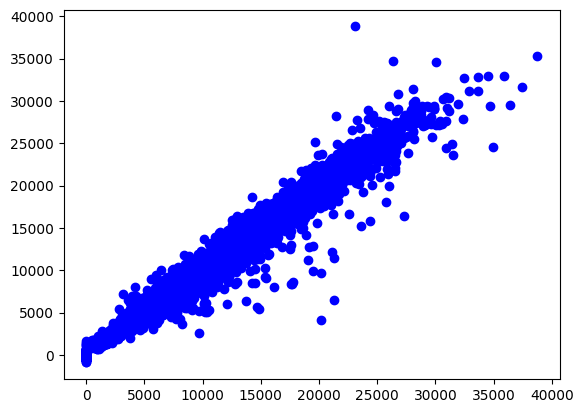

In [90]:
# lets plot the correlation between the test values and predicted values
plt.plot(y_test.values, yPred, 'bo')

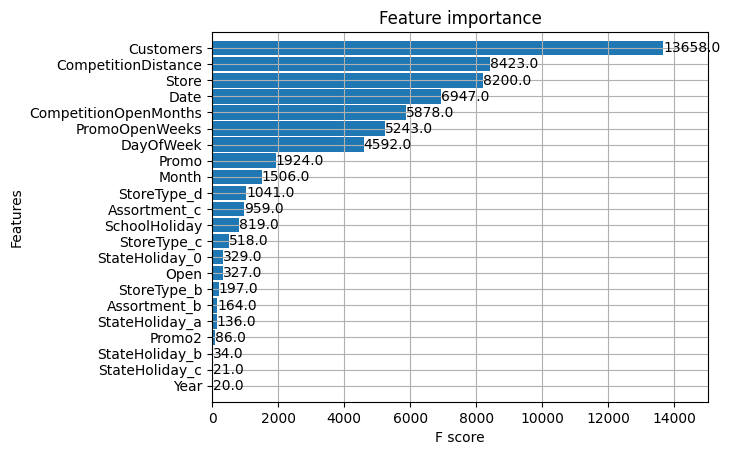

In [83]:
# Let's see the feature importance
_ = plot_importance(reg, height=0.9)

Customers, CompetitionDistance, Store number, Date and CompetitionOpenMonths are the top 5 features that affect the sales of the store. (Features with high F score are important)

**But the problem** here is that number of customers is another time series prediction problem. Hence this feature should be removed.

In [91]:
features_ = features.drop(["Customers"], axis = 1)
X_train_, X_test_, y_train_, y_test_ = model_selection.train_test_split(features_, target, test_size = 0.20)
reg.fit(X_train_, y_train_,
        eval_set=[(X_train_, y_train_), (X_test_, y_test_)],
        early_stopping_rounds=100,
        verbose=False)
yPred_ = reg.predict(X_test_)
rms_xgboost_ = np.sqrt(mean_squared_error(y_test_, yPred_))
print("Root Mean Squared Error for XGBoost_:", rms_xgboost_)

Root Mean Squared Error for XGBoost_: 743.4989518076832


Here we explored performance of SARIMA model and XGBoost Regression model on the time series data. For SARIMA we just worked on prediction of sales of store a, while for XGB model we worked on whole dataset. The perforamce can be improved by tweaking of Hyperparameters in case of machine learning model.